# 07 — Results Visualization
Generates all report-ready figures for the ISyE 6740 final paper.

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
matplotlib.rcParams['figure.dpi'] = 150
os.makedirs("../figures", exist_ok=True)

## 1. Load All Results

In [2]:
loaded_data = {}

try:
    loaded_data['price_matrix'] = pd.read_parquet("../data/raw/price_matrix.parquet")
    print("Loaded price_matrix")
except Exception as e:
    print(f"Could not load price_matrix: {e}")

try:
    loaded_data['returns_matrix'] = pd.read_parquet("../data/raw/returns_matrix.parquet")
    print("Loaded returns_matrix")
except Exception as e:
    print(f"Could not load returns_matrix: {e}")

try:
    loaded_data['fundamentals'] = pd.read_parquet("../data/raw/fundamentals.parquet")
    print("Loaded fundamentals")
except Exception as e:
    print(f"Could not load fundamentals: {e}")

try:
    loaded_data['feature_matrix'] = pd.read_parquet("../data/processed/feature_matrix.parquet")
    print("Loaded feature_matrix")
except Exception as e:
    print(f"Could not load feature_matrix: {e}")

try:
    loaded_data['pca_data'] = pd.read_parquet("../data/processed/pca_data.parquet")
    print("Loaded pca_data")
except Exception as e:
    print(f"Could not load pca_data: {e}")

try:
    loaded_data['cluster_labels'] = pd.read_parquet("../data/processed/cluster_labels.parquet")
    print("Loaded cluster_labels")
except Exception as e:
    print(f"Could not load cluster_labels: {e}")

try:
    loaded_data['forecast_results'] = pd.read_parquet("../data/processed/forecast_results.parquet")
    print("Loaded forecast_results")
except Exception as e:
    print(f"Could not load forecast_results: {e}")

try:
    loaded_data['evaluation_summary'] = pd.read_parquet("../data/processed/evaluation_summary.parquet")
    print("Loaded evaluation_summary")
except Exception as e:
    print(f"Could not load evaluation_summary: {e}")

Loaded price_matrix
Loaded returns_matrix
Loaded fundamentals
Loaded feature_matrix
Loaded pca_data
Loaded cluster_labels
Loaded forecast_results
Loaded evaluation_summary


## 2. Figure 1: Stock Price Overview

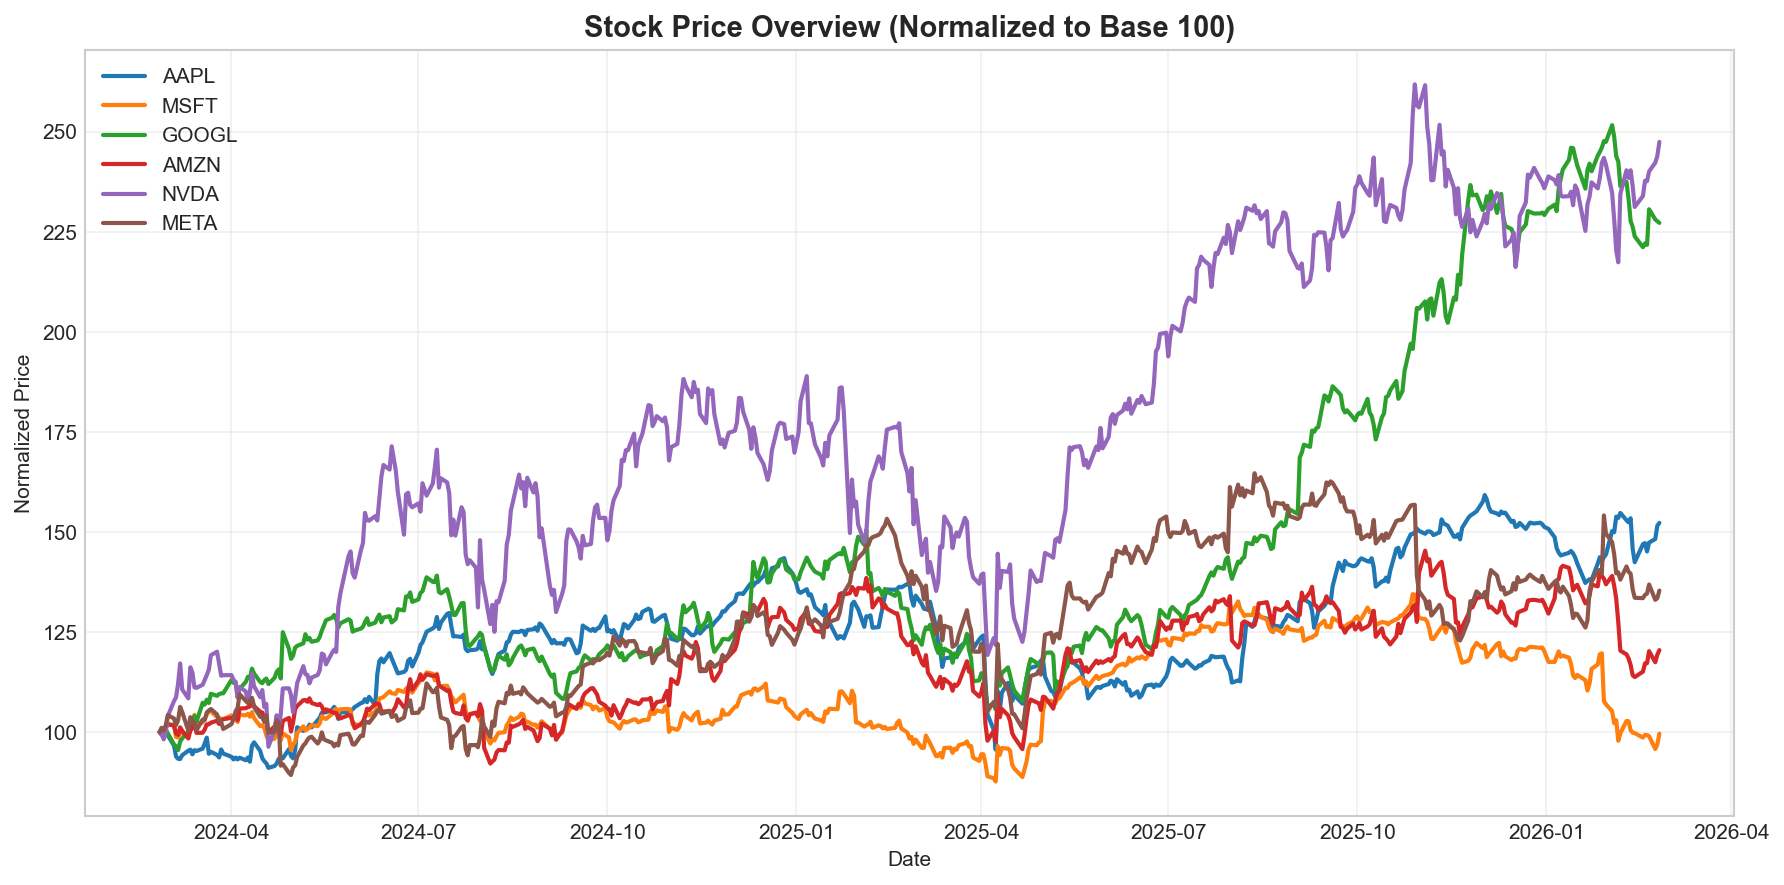

Saved fig1_price_overview.png


In [3]:
if 'price_matrix' in loaded_data:
    price_df = loaded_data['price_matrix']
    
    # Normalize to base 100
    normalized = (price_df / price_df.iloc[0]) * 100
    
    # Select 6 representative stocks
    sample_cols = normalized.columns[:6]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for col in sample_cols:
        ax.plot(normalized.index, normalized[col], label=col, linewidth=2)
    
    ax.set_title('Stock Price Overview (Normalized to Base 100)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Normalized Price')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../figures/fig1_price_overview.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved fig1_price_overview.png")
else:
    print("price_matrix not available")

## 3. Figure 2: PCA Explained Variance

Auto-selected 7 components (explaining 91.9% variance)


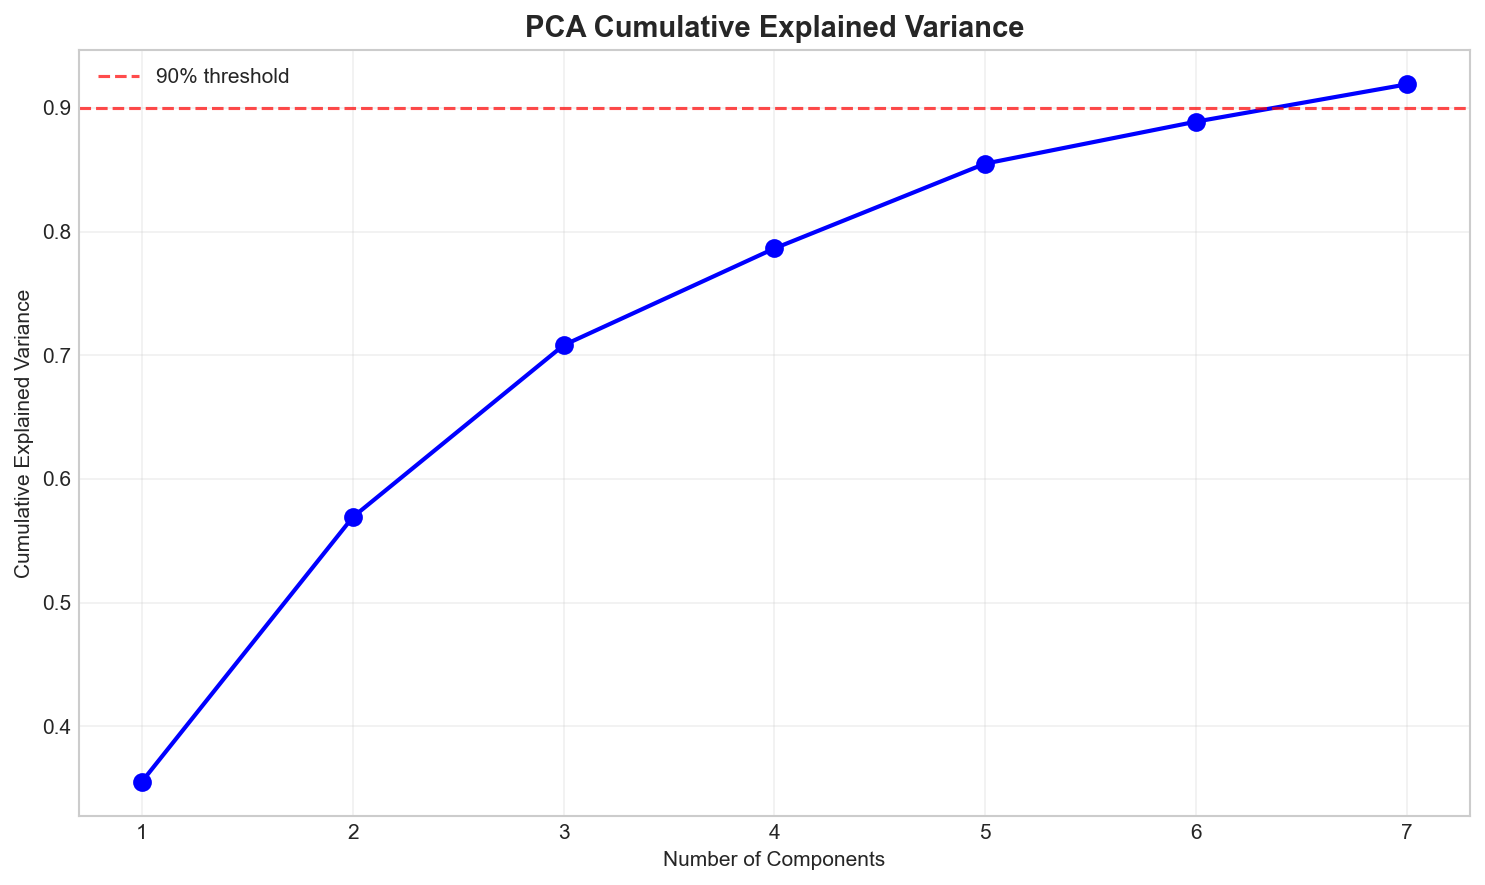

Saved fig2_pca_variance.png


In [4]:
if 'pca_data' in loaded_data and 'feature_matrix' in loaded_data:
    pca_df = loaded_data['pca_data']
    
    try:
        from src.pca_analysis import StockPCA
        
        feature_df = loaded_data['feature_matrix']
        stock_pca = StockPCA()
        stock_pca.fit_transform(feature_df)
        
        fig, ax = plt.subplots(figsize=(10, 6))
        cumsum = np.cumsum(stock_pca.pca.explained_variance_ratio_)
        ax.plot(range(1, len(cumsum) + 1), cumsum, 'bo-', linewidth=2, markersize=8)
        ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='90% threshold')
        ax.set_title('PCA Cumulative Explained Variance', fontsize=14, fontweight='bold')
        ax.set_xlabel('Number of Components')
        ax.set_ylabel('Cumulative Explained Variance')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../figures/fig2_pca_variance.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved fig2_pca_variance.png")
    except Exception as e:
        print(f"Error creating PCA plot: {e}")
else:
    print("PCA data not available")

## 4. Figure 3: Stocks in PCA Space by Sector

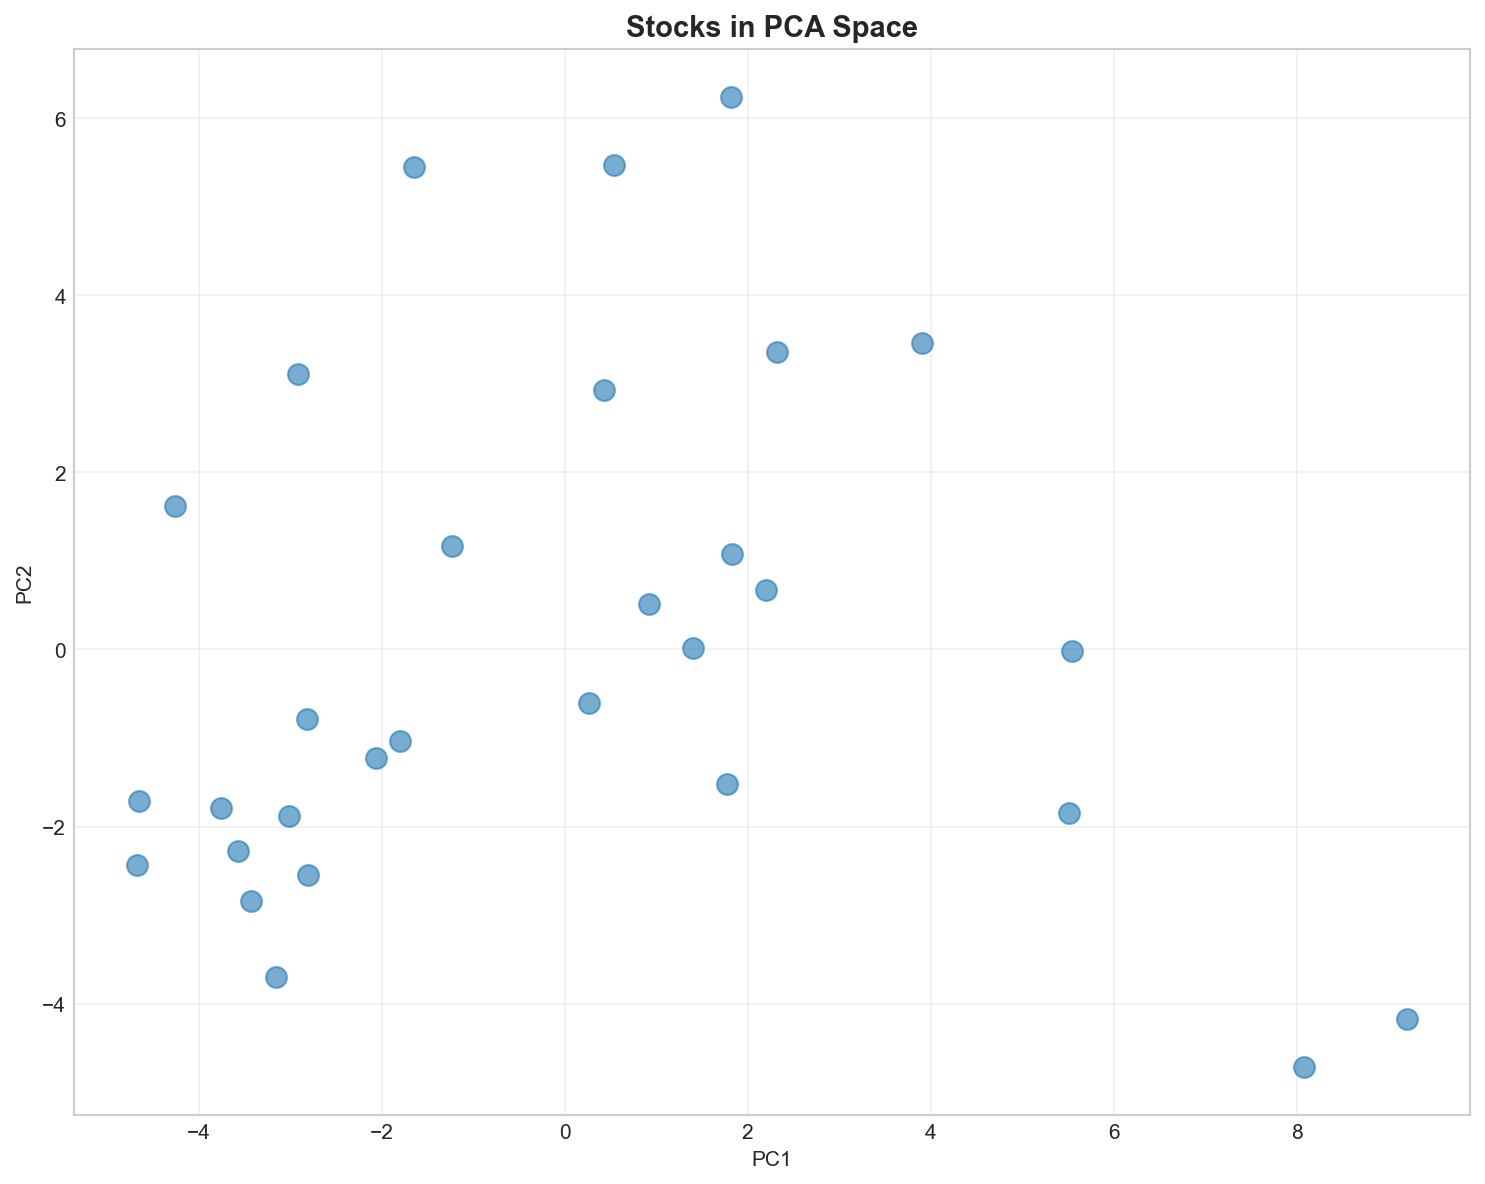

Saved fig3_pca_sectors.png


In [5]:
if 'pca_data' in loaded_data:
    pca_df = loaded_data['pca_data']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    if 'PC1' in pca_df.columns and 'PC2' in pca_df.columns:
        ax.scatter(pca_df['PC1'], pca_df['PC2'], s=100, alpha=0.6)
        ax.set_title('Stocks in PCA Space', fontsize=14, fontweight='bold')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../figures/fig3_pca_sectors.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved fig3_pca_sectors.png")
else:
    print("PCA data not available")

## 5. Figure 4: Cluster Analysis

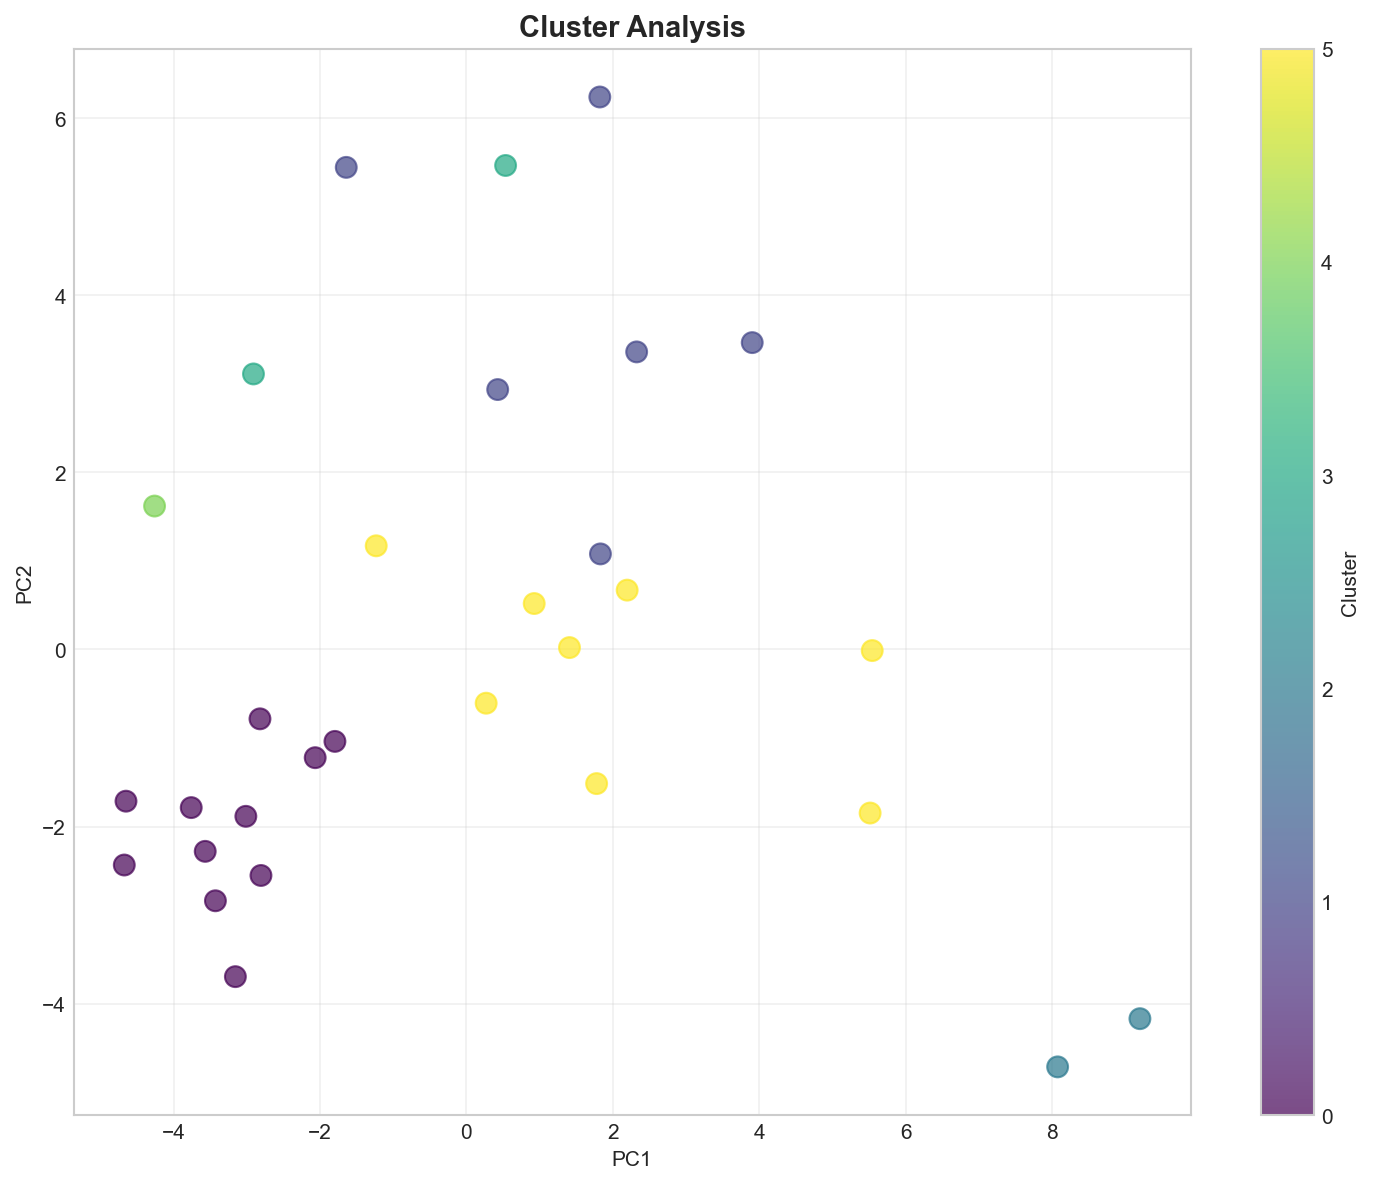

Saved fig4_clusters.png


In [6]:
if 'cluster_labels' in loaded_data and 'pca_data' in loaded_data:
    cluster_df = loaded_data['cluster_labels']
    pca_df = loaded_data['pca_data']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    if 'kmeans_cluster' in cluster_df.columns and 'PC1' in pca_df.columns and 'PC2' in pca_df.columns:
        scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], c=cluster_df['kmeans_cluster'], cmap='viridis', s=100, alpha=0.7)
        ax.set_title('Cluster Analysis', fontsize=14, fontweight='bold')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        plt.colorbar(scatter, ax=ax, label='Cluster')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../figures/fig4_clusters.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved fig4_clusters.png")
else:
    print("Cluster data not available")

## 6. Figure 5: Forecast Comparison

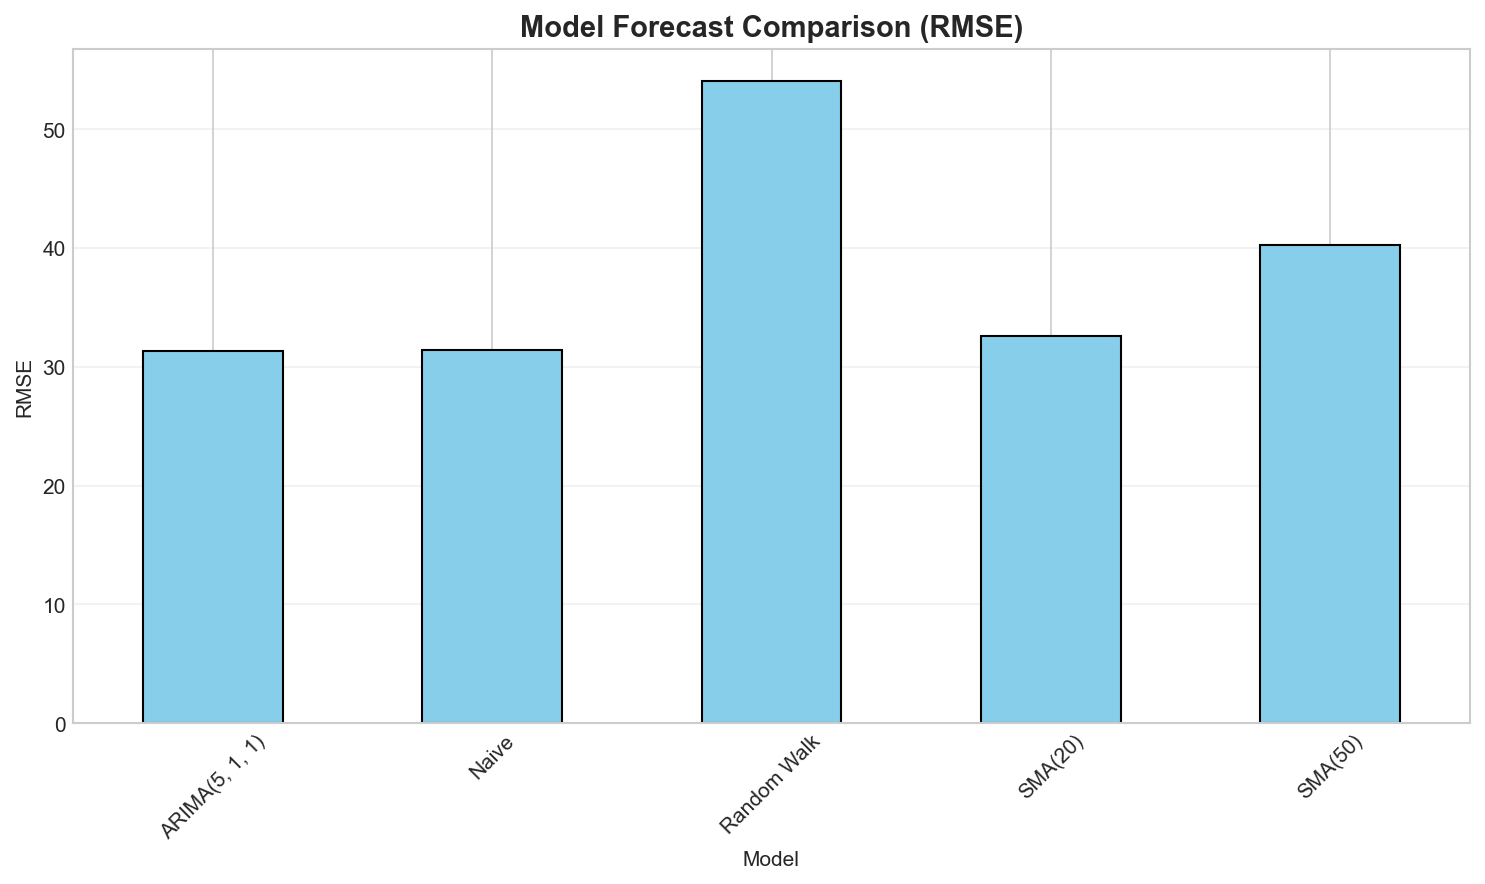

Saved fig5_forecast_comparison.png


In [7]:
if 'forecast_results' in loaded_data:
    forecast_df = loaded_data['forecast_results']
    
    try:
        grouped = forecast_df.groupby('model')['RMSE'].agg(['mean', 'std'])
        
        fig, ax = plt.subplots(figsize=(10, 6))
        grouped['mean'].plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
        ax.set_title('Model Forecast Comparison (RMSE)', fontsize=14, fontweight='bold')
        ax.set_ylabel('RMSE')
        ax.set_xlabel('Model')
        ax.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.savefig('../figures/fig5_forecast_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        print("Saved fig5_forecast_comparison.png")
    except Exception as e:
        print(f"Error creating forecast comparison: {e}")
else:
    print("Forecast results not available")

## 6b. Figure 5b: Cluster-Informed vs Baseline ARIMA
Paired comparison showing how PCA-based cluster membership affects ARIMA forecasting.

In [8]:
# Run cluster evaluation across multiple stocks for visualization
from src.data_loader import fetch_multiple_stocks
from src.baselines import ARIMAForecast
from src.evaluation import backtest_model, backtest_cluster_model

stock_data_viz = fetch_multiple_stocks(
    ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "JPM", "V", "MA",
     "GS", "JNJ", "UNH", "LLY", "MRK", "ABBV", "XOM", "CVX", "PG", "KO",
     "PEP", "WMT", "HD", "CRM", "AMD", "NFLX", "DIS", "INTC", "BA", "GE"],
    period="2y"
)
cluster_labels_viz = loaded_data['cluster_labels']
kmeans_labels = cluster_labels_viz["kmeans_cluster"]

eval_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
comparison_rows = []

for ticker in eval_tickers:
    if ticker not in stock_data_viz:
        continue
    t_series = stock_data_viz[ticker]["Close"]
    
    arima_res = backtest_model(t_series, ARIMAForecast, n_windows=3)
    ensemble_res = backtest_cluster_model(
        t_series, ticker, stock_data_viz, kmeans_labels,
        method="ensemble", self_weight=0.5, n_windows=3
    )
    
    cid = kmeans_labels.loc[ticker]
    n_peers = (kmeans_labels == cid).sum() - 1
    arima_rmse = arima_res['RMSE'].mean()
    ens_rmse = ensemble_res['RMSE'].mean()
    
    comparison_rows.append({
        'Ticker': ticker, 'Cluster': cid, 'Peers': n_peers,
        'ARIMA_RMSE': arima_rmse, 'Ensemble_RMSE': ens_rmse,
        'Improvement_Pct': (arima_rmse - ens_rmse) / arima_rmse * 100
    })

comp_df = pd.DataFrame(comparison_rows)
print(comp_df.to_string(index=False))

Fetching stock data:   0%|          | 0/30 [00:00<?, ?it/s]

Fetching stock data: 100%|██████████| 30/30 [00:00<00:00, 693.66it/s]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported 

Successfully loaded data for 30/30 tickers


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

Ticker  Cluster  Peers  ARIMA_RMSE  Ensemble_RMSE  Improvement_Pct
  AAPL        0     10    4.311290       4.465535    -3.577693e+00
  MSFT        1      5   13.071006      12.835101     1.804797e+00
 GOOGL        5      7   11.872096      11.869195     2.443282e-02
  AMZN        1      5    4.805637       4.759680     9.563167e-01
  NVDA        4      0    4.352954       4.352954     2.040404e-14


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported i

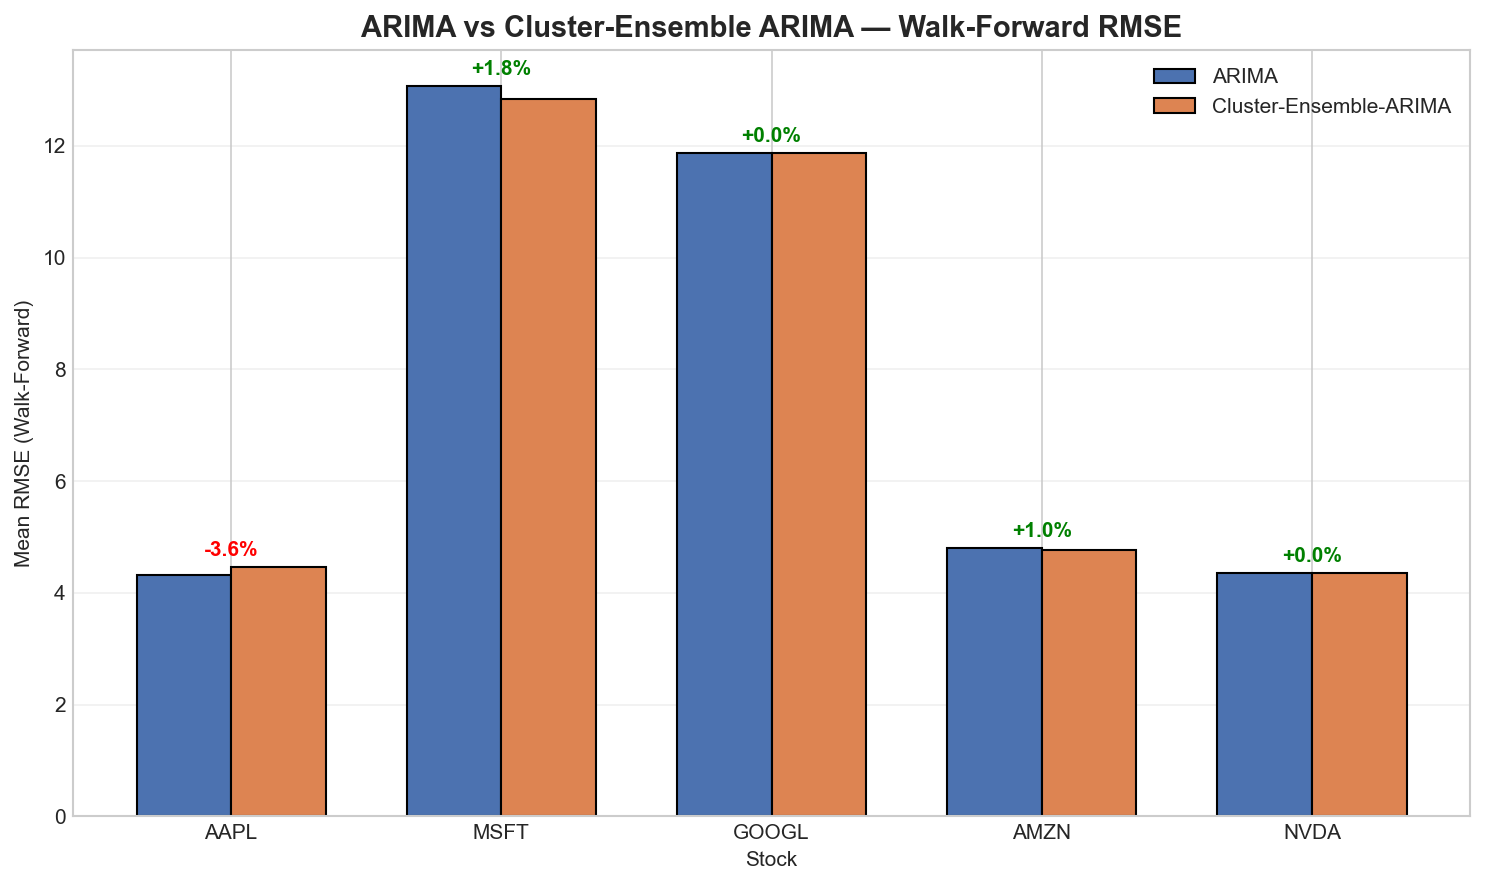

Saved fig5b_cluster_vs_arima.png


In [9]:
# Figure 5b: Paired bar chart — ARIMA vs Cluster-Ensemble ARIMA
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comp_df))
width = 0.35

bars1 = ax.bar(x - width/2, comp_df['ARIMA_RMSE'], width, label='ARIMA', color='#4C72B0', edgecolor='black')
bars2 = ax.bar(x + width/2, comp_df['Ensemble_RMSE'], width, label='Cluster-Ensemble-ARIMA', color='#DD8452', edgecolor='black')

ax.set_xlabel('Stock')
ax.set_ylabel('Mean RMSE (Walk-Forward)')
ax.set_title('ARIMA vs Cluster-Ensemble ARIMA — Walk-Forward RMSE', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comp_df['Ticker'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Annotate improvement %
for i, row in comp_df.iterrows():
    pct = row['Improvement_Pct']
    y_pos = max(row['ARIMA_RMSE'], row['Ensemble_RMSE']) + 0.2
    color = 'green' if pct > 0 else 'red'
    ax.annotate(f"{pct:+.1f}%", (x[i], y_pos), ha='center', fontsize=10, color=color, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/fig5b_cluster_vs_arima.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved fig5b_cluster_vs_arima.png")

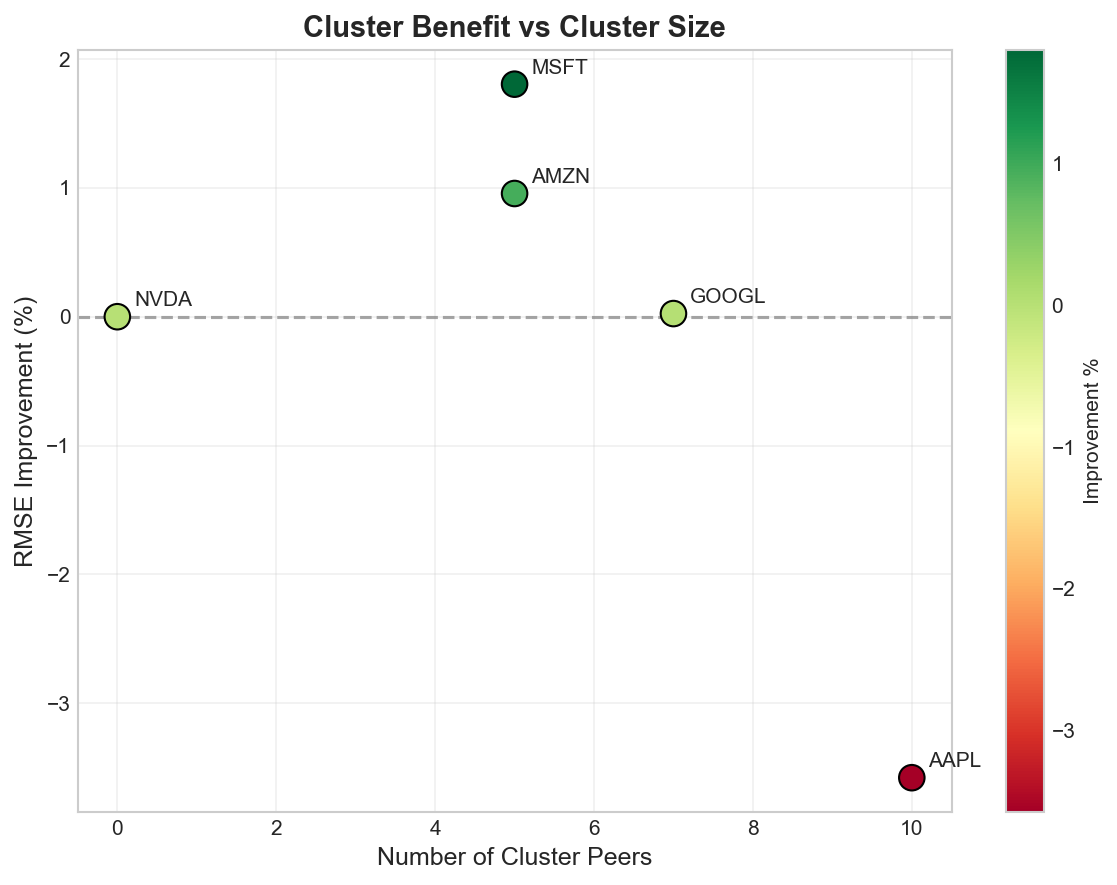

Saved fig5c_improvement_vs_cluster_size.png


In [10]:
# Figure 5c: RMSE Improvement % vs Cluster Size
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(comp_df['Peers'], comp_df['Improvement_Pct'],
                     s=150, c=comp_df['Improvement_Pct'], cmap='RdYlGn',
                     edgecolors='black', linewidths=1, zorder=5)

for _, row in comp_df.iterrows():
    ax.annotate(row['Ticker'], (row['Peers'], row['Improvement_Pct']),
                textcoords="offset points", xytext=(8, 5), fontsize=10)

ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
ax.set_xlabel('Number of Cluster Peers', fontsize=12)
ax.set_ylabel('RMSE Improvement (%)', fontsize=12)
ax.set_title('Cluster Benefit vs Cluster Size', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label='Improvement %')

plt.tight_layout()
plt.savefig('../figures/fig5c_improvement_vs_cluster_size.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved fig5c_improvement_vs_cluster_size.png")

## 7. Figure 6: Model Performance Heatmap

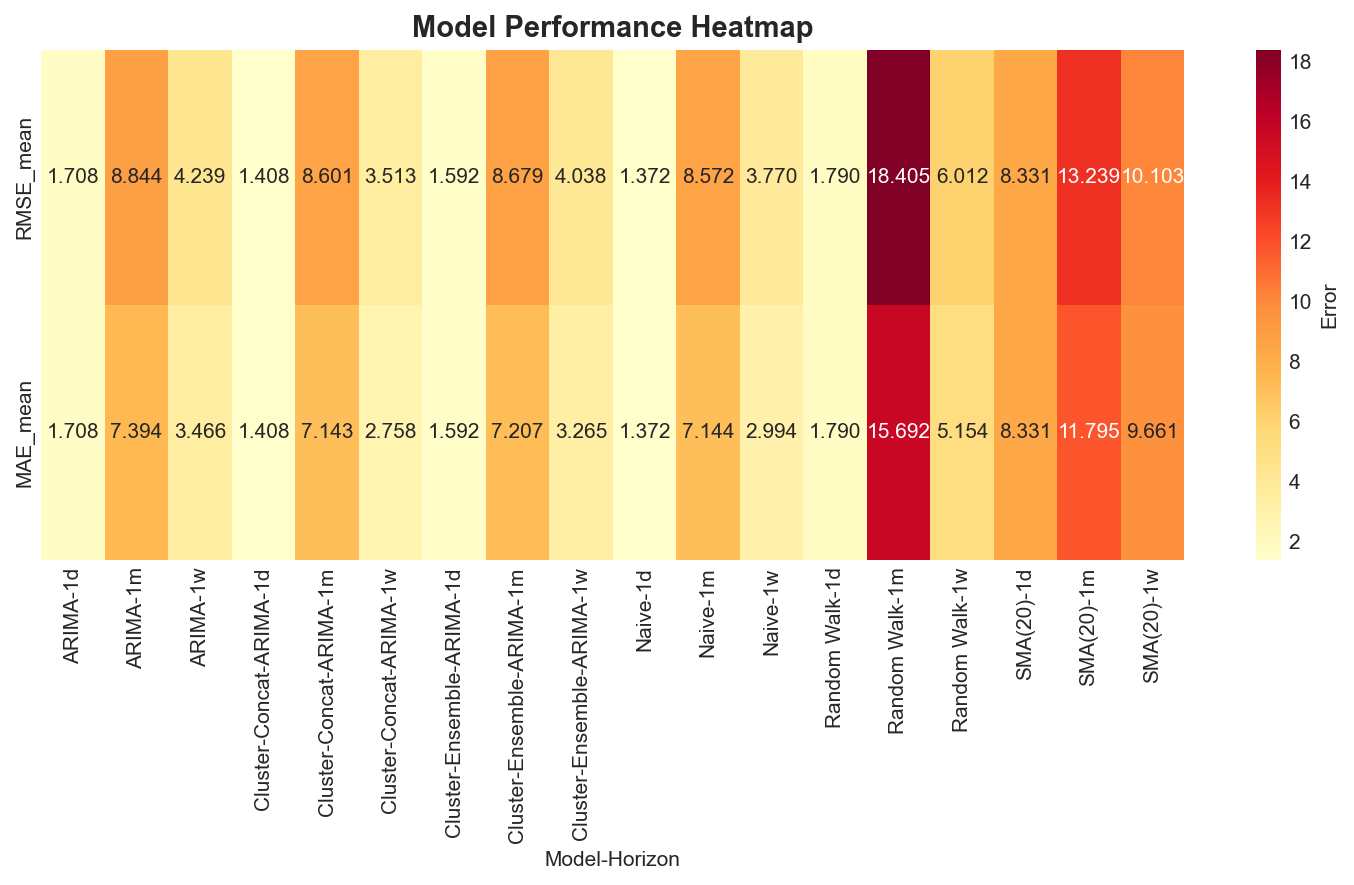

Saved fig6_model_heatmap.png


In [11]:
if 'evaluation_summary' in loaded_data:
    eval_df = loaded_data['evaluation_summary']
    
    try:
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if 'RMSE_mean' in eval_df.columns:
            sns.heatmap(eval_df[['RMSE_mean', 'MAE_mean']].T, annot=True, fmt='.3f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Error'})
            ax.set_title('Model Performance Heatmap', fontsize=14, fontweight='bold')
            
            plt.tight_layout()
            plt.savefig('../figures/fig6_model_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("Saved fig6_model_heatmap.png")
    except Exception as e:
        print(f"Error creating heatmap: {e}")
else:
    print("Evaluation summary not available")

## 8. Summary Statistics Table

In [12]:
summary_stats = {}

if 'price_matrix' in loaded_data:
    summary_stats['Price Data'] = {
        'Shape': loaded_data['price_matrix'].shape,
        'Date Range': f"{loaded_data['price_matrix'].index[0]} to {loaded_data['price_matrix'].index[-1]}"
    }

if 'feature_matrix' in loaded_data:
    summary_stats['Features'] = {
        'Shape': loaded_data['feature_matrix'].shape,
        'Features Count': loaded_data['feature_matrix'].shape[1]
    }

if 'cluster_labels' in loaded_data:
    summary_stats['Clusters'] = {
        'Num Clusters': loaded_data['cluster_labels']['kmeans_cluster'].nunique() if 'kmeans_cluster' in loaded_data['cluster_labels'].columns else 'N/A'
    }

if 'forecast_results' in loaded_data:
    summary_stats['Forecast'] = {
        'Shape': loaded_data['forecast_results'].shape,
        'Mean RMSE': loaded_data['forecast_results']['RMSE'].mean() if 'RMSE' in loaded_data['forecast_results'].columns else 'N/A'
    }

print("\nSummary Statistics:")
for category, stats in summary_stats.items():
    print(f"\n{category}:")
    for key, value in stats.items():
        print(f"  {key}: {value}")

# Save to CSV
summary_df = pd.DataFrame(summary_stats).T
summary_df.to_csv("../figures/summary_table.csv")
print("\nSummary table saved to ../figures/summary_table.csv")


Summary Statistics:

Price Data:
  Shape: (502, 30)
  Date Range: 2024-02-26 00:00:00-05:00 to 2026-02-25 00:00:00-05:00

Features:
  Shape: (30, 38)
  Features Count: 38

Clusters:
  Num Clusters: 6

Forecast:
  Shape: (25, 6)
  Mean RMSE: 37.918914209649536

Summary table saved to ../figures/summary_table.csv


## 9. Report Figures Complete

In [13]:
import glob

figure_files = glob.glob("../figures/*")
print(f"Total files in figures directory: {len(figure_files)}")
print("\nFiles generated:")
for f in sorted(figure_files):
    print(f"  {os.path.basename(f)}")

Total files in figures directory: 29

Files generated:
  01_price_overview.png
  02_correlation.png
  02_technical_indicators.png
  03_correlation_clustermap.png
  03_feature_distributions.png
  03_pca_loadings.png
  03_pca_scatter.png
  03_scree_plot.png
  05_baseline_forecasts.png
  05_cluster_forecasts.png
  06_metrics_1d.png
  06_metrics_1m.png
  06_metrics_1w.png
  06_model_comparison_mape.png
  06_model_comparison_rmse.png
  cluster_composition.png
  cluster_scatter.png
  fig1_price_overview.png
  fig2_pca_variance.png
  fig3_pca_sectors.png
  fig4_clusters.png
  fig5_forecast_comparison.png
  fig5b_cluster_vs_arima.png
  fig5c_improvement_vs_cluster_size.png
  fig6_model_heatmap.png
  gmm_cluster_scatter.png
  gmm_evaluation.png
  kmeans_evaluation.png
  summary_table.csv
